In [1]:
import openl3
import soundfile as sf

import sound_utils

from matplotlib import pyplot as plt
import IPython.display as ipd
%matplotlib inline

Using TensorFlow backend.
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prs392/miniconda3/envs/incubator/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pr

In [4]:
audio, sr = sf.read('/scratch/prs392/incubator/data/LibriSpeech/train_clean_360/LibriSpeech/train-clean-360/100/121669/100-121669-0015.flac')

audio.shape, sr


((254800,), 16000)

In [5]:
emb, ts = openl3.get_audio_embedding(audio, sr)

emb.shape, ts.shape

156/156 [==============================] - 11s 71ms/step


((156, 6144), (156,))

WAV file:  Fs = 16000, x.shape = (254800,), x.dtype = float64


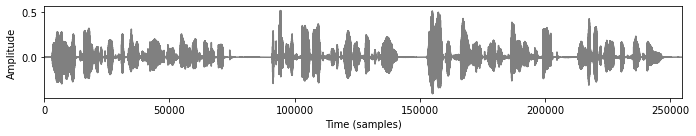

In [6]:
sound_utils.print_plot_play(x=audio, Fs=sr, text='WAV file: ')

In [14]:
import keras
import kapre
from keras.layers import Input
from kapre.time_frequency import Spectrogram, Melspectrogram
from keras.models import Model

def construct_cnn_L3_orig_audio_model():

    n_dft = 2048
    n_mels = 128
    n_hop = 242
    asr = 16000
    audio_window_dur = 1
    # INPUT
    x_a = Input(shape=(1, asr * audio_window_dur), dtype='float32')

    y_a = Melspectrogram(n_dft=n_dft, n_hop=n_hop, n_mels=n_mels,
                      sr=asr, power_melgram=1.0, htk=True, 
                      return_decibel_melgram=True, padding='same')(x_a)
    m = Model(inputs=x_a, outputs=y_a)
    m.name = 'audio_model'

    return m, x_a, y_a

In [15]:
audio_model, x_a, y_a = construct_cnn_L3_orig_audio_model()

In [16]:
x_a

<tf.Tensor 'input_2:0' shape=(?, 1, 16000) dtype=float32>

In [17]:
y_a

<tf.Tensor 'melspectrogram_2/Maximum_1:0' shape=(?, 128, 67, 1) dtype=float32>

In [10]:
import random

def sample_one_second(audio_data, sampling_frequency, augment=False):
    """Return one second audio samples randomly
    Args:
        audio_data: audio data to sample from
        sampling_frequency: audio sample rate
        augment: if True, perturb the data in some fashion
    Returns:
        One second samples, start time, and augmentation parameters
    """
    sampling_frequency = int(sampling_frequency)
    if len(audio_data) > sampling_frequency:
        start = random.randrange(len(audio_data) - sampling_frequency)
    else:
        start = 0

    audio_data = audio_data[start:start+sampling_frequency]

    if audio_data.shape[0] != sampling_frequency:
        # Pad audio that isn't one second
        warnings.warn('Got audio that is less than one second', UserWarning)
        
        audio_data = np.pad(audio_data,
                            ((0, sampling_frequency - audio_data.shape[0]),),
                            mode='constant')

    if augment:
        orig_dtype = audio_data.dtype
        audio_data = audio_data.astype(float)
        # Make sure we don't clip
        if np.abs(audio_data).max():
            max_gain = min(0.1, get_max_abs_sample_value(orig_dtype)/np.abs(audio_data).max() - 1)
        else:
            # TODO: Handle audio with all zeros
            warnings.warn('Got audio sample with all zeros', UserWarning)
            max_gain = 0.1
        gain = 1 + random.uniform(-0.1, max_gain)
        assert 0.9 <= gain <= 1.1
        audio_data *= gain

        audio_data = audio_data.astype(orig_dtype)
        audio_aug_params = {'gain': gain}
    else:
        audio_aug_params = {}

    return audio_data, start, audio_aug_params

In [11]:
audio_samples, start, params = sample_one_second(audio, sr)

In [12]:
audio_samples.shape

(16000,)

In [13]:
sr

16000

In [14]:
emb, ts = openl3.get_audio_embedding(audio_samples, sr, center=False)

1/1 [==============================] - 1s 756ms/step


In [15]:
emb.shape

(1, 6144)

WAV file:  Fs = 16000, x.shape = (16000,), x.dtype = float64


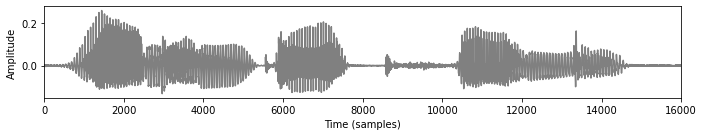

In [16]:
sound_utils.print_plot_play(x=audio_samples, Fs=16000, text='WAV file: ')

In [17]:
import tensorflow as tf
x_a = tf.convert_to_tensor(audio_samples, dtype=tf.float32)

In [18]:
x_a.shape

TensorShape([Dimension(16000)])

In [19]:
x_a = tf.reshape(
    x_a, (1, 16000), name=None
)

In [20]:
x_a

<tf.Tensor 'Reshape:0' shape=(1, 16000) dtype=float32>

In [21]:
import librosa

In [31]:
n_dft = 2048
n_mels = 128
n_hop = 242
asr = 16000
audio_window_dur = 1

spect = librosa.feature.melspectrogram(y=audio_samples, sr = 16000, n_mels=n_mels, n_fft=n_dft, hop_length=242, center=False, )


In [54]:
spect.shape

(128, 58)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

%matplotlib inline

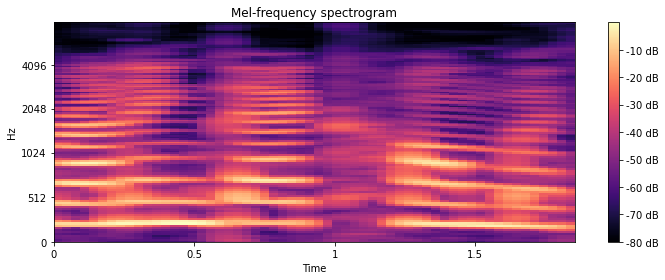

In [36]:

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [107]:
import keras
from keras.layers import Input
from keras.models import Model
from keras.models import Sequential
import kapre
from kapre.time_frequency import Spectrogram, Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise


# # 6 channels (!), maybe 1-sec audio signal, for an example.
# input_shape = (6, 44100)
# sr = 44100
# model = Sequential()
# # A mel-spectrogram layer
# model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
#                          padding='same', sr=sr, n_mels=128,
#                          fmin=0.0, fmax=sr/2, power_melgram=1.0,
#                          return_decibel_melgram=False, trainable_fb=False,
#                          trainable_kernel=False,
#                          name='trainable_stft'))
# # Maybe some additive white noise.
# model.add(AdditiveNoise(power=0.2))
# # If you wanna normalise it per-frequency
# model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'
# # After this, it's just a usual keras workflow. For example..
# # Add some layers, e.g., model.add(some convolution layers..)
# # Compile the model
# model.compile('adam', 'categorical_crossentropy') # if single-label classification
# # train it with raw audio sample inputs
# x = load_x() # e.g., x.shape = (10000, 6, 44100)
# y = load_y() # e.g., y.shape = (10000, 10) if it's 10-class classification
# # and train it
# model.fit(x, y)
# # Done!

n_dft = 2048
n_mels = 128
n_hop = 242
asr = 16000
audio_window_dur = 1
# INPUT
x_a = Input(shape=(1, asr * audio_window_dur), dtype='float32')

y_a = Melspectrogram(n_dft=n_dft, n_hop=n_hop, n_mels=n_mels,
                  sr=asr, power_melgram=1.0, htk=False, 
                  return_decibel_melgram=True, padding='valid')(x_a)
m = Model(inputs=x_a, outputs=y_a)
m.name = 'audio_model'

In [108]:
src_batch = audio_samples[np.newaxis, np.newaxis, :]

(1, 128, 58, 1)


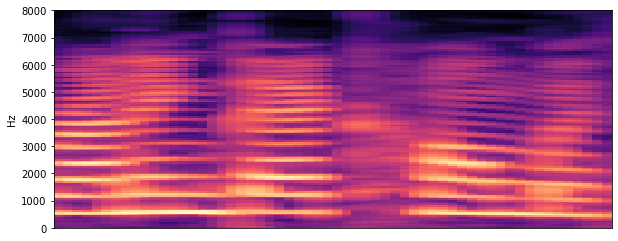

In [110]:
plt.figure(figsize=(10, 4))
pred = m.predict(src_batch)
print(pred.shape)
result = pred[0, :, :, 0]
librosa.display.specshow(result, y_axis='linear', sr=16000)

(1, 128, 58, 1)


Text(0.5, 1.0, 'log-Spectrogram by Librosa')

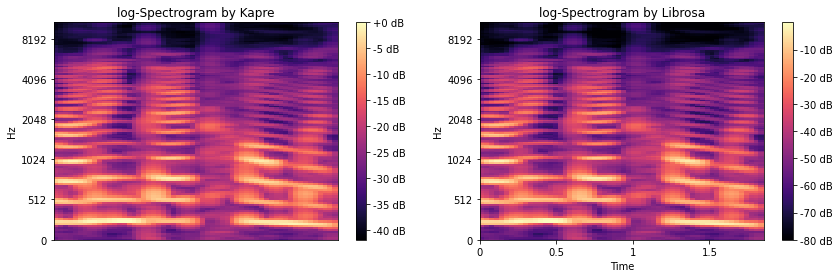

In [111]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-Spectrogram by Kapre')

src_batch = audio_samples[np.newaxis, np.newaxis, :]
pred = m.predict(src_batch)
print(pred.shape)
result = pred[0, :, :, 0]
# result = librosa.power_to_db(result, ref=np.max)
librosa.display.specshow(result, y_axis='mel', sr=16000)
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
spect = librosa.feature.melspectrogram(y=audio_samples, sr = 16000, n_mels=n_mels, n_fft=n_dft, hop_length=242, center=False)

S_dB = librosa.power_to_db(spect, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('log-Spectrogram by Librosa')

In [112]:
result, S_dB

(array([[-27.824018, -26.882017, -26.402866, ..., -24.648361, -23.554985,
         -23.406734],
        [-29.363594, -27.870718, -27.283632, ..., -23.42186 , -22.517069,
         -22.670664],
        [-27.368673, -27.05518 , -27.147137, ..., -25.326553, -24.017706,
         -23.854637],
        ...,
        [-40.396988, -39.269928, -38.0142  , ..., -35.45968 , -35.273727,
         -35.037155],
        [-40.63652 , -39.76468 , -38.676502, ..., -34.188988, -34.796276,
         -35.469704],
        [-39.67972 , -39.18264 , -38.275726, ..., -33.438602, -33.450363,
         -33.58969 ]], dtype=float32),
 array([[-55.648037, -53.764046, -52.805737, ..., -49.29672 , -47.109974,
         -46.813477],
        [-58.727173, -55.741417, -54.56729 , ..., -46.843716, -45.03414 ,
         -45.34133 ],
        [-54.737328, -54.110348, -54.294285, ..., -50.653114, -48.035416,
         -47.709274],
        ...,
        [-80.      , -78.53985 , -76.02838 , ..., -70.919365, -70.547455,
         -70.07431 

In [116]:
y = librosa.feature.inverse.mel_to_audio(spect, sr=16000, n_fft=n_dft, hop_length=242, center=False, n_iter=32, length=len(audio_samples))


WAV file:  Fs = 16000, x.shape = (16000,), x.dtype = float32


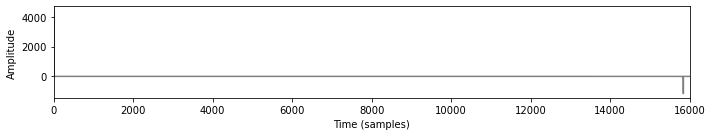

In [117]:
sound_utils.print_plot_play(x=y, Fs=16000, text='WAV file: ')